In [1]:
import pandas as pd
import nltk

### Naive approach
https://towardsdatascience.com/naive-bayes-document-classification-in-python-e33ff50f937e

In [2]:
# load the matching document contents
df_text = pd.read_csv("data/trackGBV_xls_match.csv")
print(len(df_text))
df_text.head(-5)

809


,docid,contents
0,80380,Home | Databases | WorldLII | Search | Feedbac...
1,78839,Home | Databases | WorldLII | Search | Feedbac...
2,248796,State v Lagivere - Sentence [2017] FJHC 386...
3,257586,State v Goundar - Sentence [2018] FJHC 438;...
4,80121,Home | Databases | WorldLII | Search | Feedbac...
...,...,...
799,79035,Home | Databases | WorldLII | Search | Feedbac...
800,249470,Kumar v State [2018] FJHC 583; HAA05.2018 (...
801,268266,Rashid v State [2015] FJCA 49; AAU03.2014 (...
802,79400,Home | Databases | WorldLII | Search | Feedbac...


In [3]:
df_labels = pd.read_csv("data/trackGBV_labels.csv")
print(len(df_text))
df_labels.head(-5)

809


,DocID,Customary_Practices,Gender_Stereotypes,Other_Factors,Num_Factors,Discrimination_Label
0,69815,0,0,1,1,1
1,69881,1,0,1,2,1
2,70042,0,0,0,0,0
3,70139,1,0,1,2,1
4,70164,0,1,0,1,1
...,...,...,...,...,...,...
799,285793,0,1,0,1,1
800,285800,0,0,0,0,0
801,285849,0,1,1,2,1
802,286739,0,0,0,0,0


In [4]:
# merge the two together
df = df_text.merge(df_labels, left_on='docid', right_on='DocID')
df


,docid,contents,DocID,Customary_Practices,Gender_Stereotypes,Other_Factors,Num_Factors,Discrimination_Label
0,80380,Home | Databases | WorldLII | Search | Feedbac...,80380,0,0,1,1,1
1,78839,Home | Databases | WorldLII | Search | Feedbac...,78839,0,0,1,1,1
2,248796,State v Lagivere - Sentence [2017] FJHC 386...,248796,0,0,0,0,0
3,257586,State v Goundar - Sentence [2018] FJHC 438;...,257586,1,1,0,2,1
4,80121,Home | Databases | WorldLII | Search | Feedbac...,80121,0,1,0,1,1
...,...,...,...,...,...,...,...,...
804,75927,Home | Databases | WorldLII | Search | Feedbac...,75927,0,0,0,0,0
805,247181,State v Khelawan [2016] FJMC 41; Criminal C...,247181,0,1,0,1,1
806,271413,Bulivou v State [2014] FJCA 215; AAU78.2010...,271413,0,0,0,0,0
807,252935,State v Lal [2015] FJMC 58; Criminal Case 1...,252935,0,0,0,0,0


In [5]:
#split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['contents'], df['Discrimination_Label'], 
                                                    random_state=1)

In [6]:
# Word Counting
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(strip_accents='ascii', 
                     token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', 
                     lowercase=True, 
                     stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [7]:
# check training data
word_freq_df = pd.DataFrame(X_train_cv.toarray(), columns=cv.get_feature_names())
top_words_df = pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False)

In [8]:
print(top_words_df)

             0
court     8837
years     7929
sentence  7533
accused   4998
state     4764
...        ...
lautiki      1
laulaba      1
latent       1
lateness     1
zubair       1

[15361 rows x 1 columns]


In [9]:
# train and predict
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_cv, y_train)
predictions = naive_bayes.predict(X_test_cv)

In [10]:
# check scores
from sklearn.metrics import accuracy_score, precision_score, recall_score
print('Accuracy score: ', accuracy_score(y_test, predictions))
print('Precision score: ', precision_score(y_test, predictions))
print('Recall score: ', recall_score(y_test, predictions))

Accuracy score:  0.7093596059113301
Precision score:  0.7018633540372671
Recall score:  0.9112903225806451


Text(91.68, 0.5, 'predicted label')

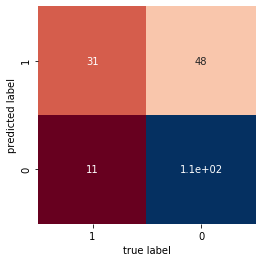

In [46]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False,
xticklabels=['1', '0'], yticklabels=['1', '0'])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [47]:
testing_predictions = []
for i in range(len(X_test)):
    if predictions[i] == 1:
        testing_predictions.append('1')
    else:
        testing_predictions.append('0')
check_df = pd.DataFrame({'actual_label': list(y_test), 'prediction': testing_predictions, 'contents':list(X_test)})
check_df.replace(to_replace=0, value='1', inplace=True)
check_df.replace(to_replace=1, value='0', inplace=True)

In [48]:
check_df

,actual_label,prediction,contents
0,0,1,Home | Databases | WorldLII | Search | Feedbac...
1,0,1,Home | Databases | WorldLII | Search | Feedbac...
2,1,1,State v Tatoro - Sentence [2016] FJHC 347; ...
3,0,1,State v Waqa - Sentence [2016] FJHC 531; HA...
4,1,1,State v Zubair - Sentence [2017] FJHC 895; ...
...,...,...,...
198,0,1,Home | Databases | WorldLII | Search | Feedbac...
199,0,1,Home | Databases | WorldLII | Search | Feedbac...
200,1,1,State v Balak [2015] FJHC 709; HAC260.2014 ...
201,0,1,State v Chand [2015] FJMC 77; Criminal Case...


In [36]:
X_test[0]

'Home | Databases | WorldLII | Search | Feedback\nHigh Court of Fiji\nYou are here:\xa0 PacLII >> Databases >> High Court of Fiji >> 2011 >> [2011] FJHC 641\n\nDatabase Search | Name Search | Recent Decisions | Noteup | LawCite | Download | Help\n\nState v Ram - Sentence [2011] FJHC 641; HAC033.2010L (12 October 2011) \nIN THE HIGH COURT OF FIJI\nAT LAUTOKA\nCRIMINAL JURISDICTION\n\nCRIMINAL CASE NO.: HAC 033 OF 2010L\n\nBETWEEN:\n\nSTATE\n\nAND :\n\nFELIX RAM\n\nMr F. Lacanivalu for the State\nMs. V. Tamanisau [LAC] for the Accused\n\nDate of Hearing : 11th October, 2011.\nDate of Sentence : 12th October, 2011.\n\nSENTENCE\n[Child Rape]\n\n[1] On the 11th October 2011 the accused entered a plea of guilty to one charge of rape contrary to Section 207(1) & (2) (b) of the Crimes Decree 2009, the particulars being that on the 14th March 2010 at Uciwai settlement, Korolevu he raped a child with his finger. He agreed to facts put to him, whereupon he was found guilty and convicted.\n\n[2] T

In [39]:
df['contents'][20]

'Home | Databases | WorldLII | Search | Feedback\nHigh Court of Fiji\nYou are here:\xa0 PacLII >> Databases >> High Court of Fiji >> 2011 >> [2011] FJHC 641\n\nDatabase Search | Name Search | Recent Decisions | Noteup | LawCite | Download | Help\n\nState v Ram - Sentence [2011] FJHC 641; HAC033.2010L (12 October 2011) \nIN THE HIGH COURT OF FIJI\nAT LAUTOKA\nCRIMINAL JURISDICTION\n\nCRIMINAL CASE NO.: HAC 033 OF 2010L\n\nBETWEEN:\n\nSTATE\n\nAND :\n\nFELIX RAM\n\nMr F. Lacanivalu for the State\nMs. V. Tamanisau [LAC] for the Accused\n\nDate of Hearing : 11th October, 2011.\nDate of Sentence : 12th October, 2011.\n\nSENTENCE\n[Child Rape]\n\n[1] On the 11th October 2011 the accused entered a plea of guilty to one charge of rape contrary to Section 207(1) & (2) (b) of the Crimes Decree 2009, the particulars being that on the 14th March 2010 at Uciwai settlement, Korolevu he raped a child with his finger. He agreed to facts put to him, whereupon he was found guilty and convicted.\n\n[2] T

,docid,contents,DocID,Customary_Practices,Gender_Stereotypes,Other_Factors,Num_Factors,Discrimination_Label
0,80380,Home | Databases | WorldLII | Search | Feedbac...,80380,0,0,1,1,1
1,78839,Home | Databases | WorldLII | Search | Feedbac...,78839,0,0,1,1,1
2,248796,State v Lagivere - Sentence [2017] FJHC 386...,248796,0,0,0,0,0
3,257586,State v Goundar - Sentence [2018] FJHC 438;...,257586,1,1,0,2,1
4,80121,Home | Databases | WorldLII | Search | Feedbac...,80121,0,1,0,1,1
...,...,...,...,...,...,...,...,...
804,75927,Home | Databases | WorldLII | Search | Feedbac...,75927,0,0,0,0,0
805,247181,State v Khelawan [2016] FJMC 41; Criminal C...,247181,0,1,0,1,1
806,271413,Bulivou v State [2014] FJCA 215; AAU78.2010...,271413,0,0,0,0,0
807,252935,State v Lal [2015] FJMC 58; Criminal Case 1...,252935,0,0,0,0,0


# Another approach
https://github.com/saadarshad102/Sentiment-Analysis-CNN/blob/master/Notebook.ipynb

In [105]:
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import collections
import re
import string

In [106]:
pos = []
neg = []
for l in df.Discrimination_Label:
    if l == 0:
        pos.append(0)
        neg.append(1)
    elif l == 1:
        pos.append(1)
        neg.append(0)
df['Pos']= pos
df['Neg']= neg

data = df[['Text_Final', 'tokens', 'Discrimination_Label', 'Pos', 'Neg']]
data.head()

,Text_Final,tokens,Discrimination_Label,Pos,Neg
0,home databases worldlii search feedback high c...,"[home, databases, worldlii, search, feedback, ...",1,1,0
1,home databases worldlii search feedback high c...,"[home, databases, worldlii, search, feedback, ...",1,1,0
2,state v lagivere sentence 2017 fjhc 386 hac132...,"[state, v, lagivere, sentence, 2017, fjhc, 386...",0,0,1
3,state v goundar sentence 2018 fjhc 438 hac1762...,"[state, v, goundar, sentence, 2018, fjhc, 438,...",1,1,0
4,home databases worldlii search feedback high c...,"[home, databases, worldlii, search, feedback, ...",1,1,0


In [107]:
# clean dataimport re
punc = '!"#$%&''()*+,-./:;<=>?@[\]^_`{|}~'
import re

def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+punc+']', '', text)
    return text_nopunct
df['Text_Clean'] = df['contents'].apply(lambda x: remove_punct(x))

In [108]:
from nltk import word_tokenize
nltk.download('punkt')
tokens = [word_tokenize(sen) for sen in df.Text_Clean]

[nltk_data] Downloading package punkt to /Users/chris/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [109]:
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [110]:
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

df['Text_Clean'] = df['contents'].apply(lambda x: remove_punct(x))

In [111]:
from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(sen) for sen in df.Text_Clean]

In [112]:
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [113]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

In [100]:
def remove_stop_words(tokens): 
    return [word for word in tokens if word not in stoplist]

In [101]:
filtered_words = [remove_stop_words(sen) for sen in lower_tokens]

In [102]:
result = [' '.join(sen) for sen in filtered_words]

In [103]:
df['Text_Final'] = result

In [104]:
df['tokens'] = filtered_words

In [114]:
data = df[['Text_Final', 'tokens', 'Discrimination_Label', 'Pos', 'Neg']]

In [115]:
data[:4]

,Text_Final,tokens,Discrimination_Label,Pos,Neg
0,home databases worldlii search feedback high c...,"[home, databases, worldlii, search, feedback, ...",1,1,0
1,home databases worldlii search feedback high c...,"[home, databases, worldlii, search, feedback, ...",1,1,0
2,state v lagivere sentence 2017 fjhc 386 hac132...,"[state, v, lagivere, sentence, 2017, fjhc, 386...",0,0,1
3,state v goundar sentence 2018 fjhc 438 hac1762...,"[state, v, goundar, sentence, 2018, fjhc, 438,...",1,1,0


### Split data into test and train¶

In [116]:
data_train, data_test = train_test_split(data, test_size=0.10, random_state=42)

In [117]:
#build training vocabulary and get maximum training document length and total number of words training data
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

649906 words total, with a vocabulary size of 20902
Max sentence length is 15937


In [118]:
#build testing vocabulary and get maximum testing document length and total number of words in testing data
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

72804 words total, with a vocabulary size of 7036
Max sentence length is 4062


In [119]:
#Loading Google News Word2Vec model
word2vec_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [120]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

### Get Embeddings

In [121]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

In [122]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

### Tokenize and Pad sequences

In [124]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 20903 unique tokens.


In [125]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [126]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(20904, 300)


In [127]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

### Define CNN

In [128]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [129]:
label_names = ['Pos', 'Neg']

In [130]:
y_train = data_train[label_names].values

In [131]:
x_train = train_cnn_data
y_tr = y_train

In [132]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      6271200     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 49, 200)      120200      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 48, 200)      180200      embedding_1[0][0]                
____________________________________________________________________________________________

### Train CNN

In [133]:
num_epochs = 3
batch_size = 34

In [134]:
hist = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Train on 655 samples, validate on 73 samples
Epoch 1/3
655/655 [==============================] - 2s 3ms/step - loss: 0.8761 - acc: 0.5321 - val_loss: 0.6456 - val_acc: 0.6164
Epoch 2/3
655/655 [==============================] - 1s 2ms/step - loss: 0.6528 - acc: 0.6145 - val_loss: 0.6397 - val_acc: 0.6644
Epoch 3/3
655/655 [==============================] - 1s 2ms/step - loss: 0.6345 - acc: 0.6153 - val_loss: 0.6672 - val_acc: 0.6027


### Test CNN

In [136]:
predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)

81/81 [==============================] - 0s 1ms/step


In [137]:
labels = [1, 0]

In [138]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [140]:
sum(data_test.Discrimination_Label==prediction_labels)/len(prediction_labels)

0.691358024691358

In [142]:
data_test.Discrimination_Label.value_counts()

1    51
0    30
Name: Discrimination_Label, dtype: int64